# Estimating archaic TMRCAs from the real data

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(scales)
library(lemon)
library(cowplot)

devtools::load_all(".")
})

plan(multiprocess)

Loading ychr


### Estimate TMRCA of A00 and present-day non-Africans

In [2]:
highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = 3, maxdp = 0.98)

In [3]:
step1 <- run_step1(highcov_gt)

In [4]:
step1 %>% summarise_if(is.numeric, mean)

a,b,c,d,e,f,total,mut_rate,tmrca_afr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
976,1.153846,7.615385,198.4615,11.84615,1002.846,5785339,7.167508e-10,243052.2


### Estimate TMRCA between archaic Y chromosomes and present-day humans

All variations of filtering, substitution types, coverage cutoffs...

In [5]:
estimate_grid <- function(samples, regions, mindp) {
    filters <- c("filt50" = "/mnt/454/HighCovNeandertalGenome/Hengs_Alignability_Filter/hs37m_filt35_50.bed.gz",
                 "filt100" = "/mnt/454/HighCovNeandertalGenome/Hengs_Alignability_Filter/hs37m_filt35_99.bed.gz")
    
    map_dfr(samples, function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            map_dfr(c("filt50", "filt100"), function(filt) {
                future_map_dfr(mindp, function(dp) {
                    read_genotypes(arch, regions, mindp = dp, maxdp = 0.98, tv_only = (sites == "tv_only"),
                                   bed_filter = filters[filt]) %>%
                        run_step2(step1) %>%
                        mutate(dp = dp, sites = sites, filt = filt, capture = regions)
                })
            })
        })
    })
}

In [6]:
tmrca_full_low <- estimate_grid(c("den4", "den8", "spy1", "shotgun_mez2", "shotgun_spy1"), "full", 1:8)
tmrca_full_high <- estimate_grid(c("mez2", "mez2_snpad"), "full", 1:20)
tmrca_full_subsampled <- estimate_grid(paste0("mez2_dp", 1:10), "full", 1:10)
tmrca_lippold <- estimate_grid("elsidron2", "lippold", 1:20)
tmrca_exome <- estimate_grid("elsidron1", "exome", 1:8)

In [7]:
tmrca_df <- bind_rows(tmrca_full_low, tmrca_full_high, tmrca_full_subsampled, tmrca_lippold, tmrca_exome)

In [8]:
saveRDS(tmrca_df, here("data/rds/tmrca_df.rds"))

### Minimum coverage cutoff vs branch counts (how low can we go?)

In [9]:
branch_proportions <- function(df) {
    arch_branches <- df %>%
        mutate(arch = fix_name(arch)) %>%
        mutate(n_muts = a + b + c + d + e + f) %>%
        select(arch, dp, a, b, c, d, e, f, total, n_muts, sites) %>%
        gather(branch, count, -c(arch, dp, total, n_muts, sites)) %>% 
        mutate(prop = count / n_muts,
               dp = factor(dp)) %>%
        mutate(arch = fct_relevel(arch, "El Sidrón 1253", "Spy 94a", after = Inf))

    arch_branches_top    <- select(arch_branches, arch, dp, sites, branch, prop) %>% group_by(arch, dp, sites, branch) %>% top_n(1, prop) %>% rename(max_prop = prop)
    arch_branches_bottom <- select(arch_branches, arch, dp, sites, branch, prop) %>% group_by(arch, dp, sites, branch) %>% top_n(-1, prop) %>% rename(min_prop = prop)

    ggplot() +
        # upper and lower limits of observed branch counts
        geom_errorbar(data = inner_join(arch_branches_top, arch_branches_bottom),
                      aes(x = dp, ymin = min_prop, ymax = max_prop, color = branch), width = 0, size = 0.1) +

        # a and d branches
        geom_line(data = filter(arch_branches, branch %in% c("a", "d")) %>%
                                group_by(arch, dp, sites, branch) %>%
                                summarise_if(is.numeric, mean),
                  aes(dp, prop, color = branch, group = branch), linetype = 1, size = 0.25) +

        # other branches
        geom_line(data = filter(arch_branches, !branch %in% c("a", "d")) %>%
                                group_by(arch, dp, sites, branch) %>%
                                summarise_if(is.numeric, mean),
                  aes(dp, prop, color = branch, group = branch), linetype = 2, size = 0.25) +

        # mean branch count proportions
        geom_point(data = group_by(arch_branches, arch, dp, sites, branch) %>% summarise_if(is.numeric, mean),
                   aes(dp, prop, color = branch), size = 1/3) +

        geom_vline(xintercept = 3, linetype = 2, size = 1/5, alpha = 1/2, color = "black") +

        theme_bw() +
        theme(
            panel.border=element_blank(), 
            strip.text.x = element_text(size = 10),
            strip.background = element_blank(),
            axis.line = element_line(size = 1/4),
            legend.position = "right"
        ) +
        xlab("minimum coverage cutoff") +
        ylab("proportion of all mutations") +
        background_grid(major = "xy", minor = "xy", size.major = 0.2, size.minor = 0.2,
                        color.major = rgb(0.8, 0.8, 0.8, alpha = 0.5),
                        color.minor = rgb(0.8, 0.8, 0.8, alpha = 0.5)) +
        coord_capped_cart(ylim = c(0, 1), bottom = "both", left = "both") +
        facet_wrap(~ arch, ncol = 2, scales = "free") +
        guides(col = guide_legend(ncol = 1), linetype = FALSE)
}

There needs to be a balance between:

* avoiding false SNPs due to low coverage
* mapping only reference-like sites

The `f` branch (length of the private archaic lineage) is a good measure for this. It is expected to be very long when the lower cutoff is low (for example, all DNA damage and sequencing errors will manifest as true SNPs when using even single reads), but shorten as we increase the cutoff. The danger is, of course, that a very strict filtering cutoff will allow only sites in reference-like regions to be considered.

Using the `e` branch counts as in Mendez et al. unreliable, because it changes significantly with coverage cutoffs. Luckily, the `d` and `a` branches become relatively stable with lower coverage cutoff as low as 3X. It is easy to derive a formula for $\alpha$ that avoid `e` completely.

Warning message:
“Unknown levels in `f`: El Sidrón 1253, Spy 94a”Joining, by = c("arch", "dp", "sites", "branch")
Warning message:
“Removed 36 rows containing missing values (geom_point).”Warning message:
“Removed 36 rows containing missing values (geom_point).”

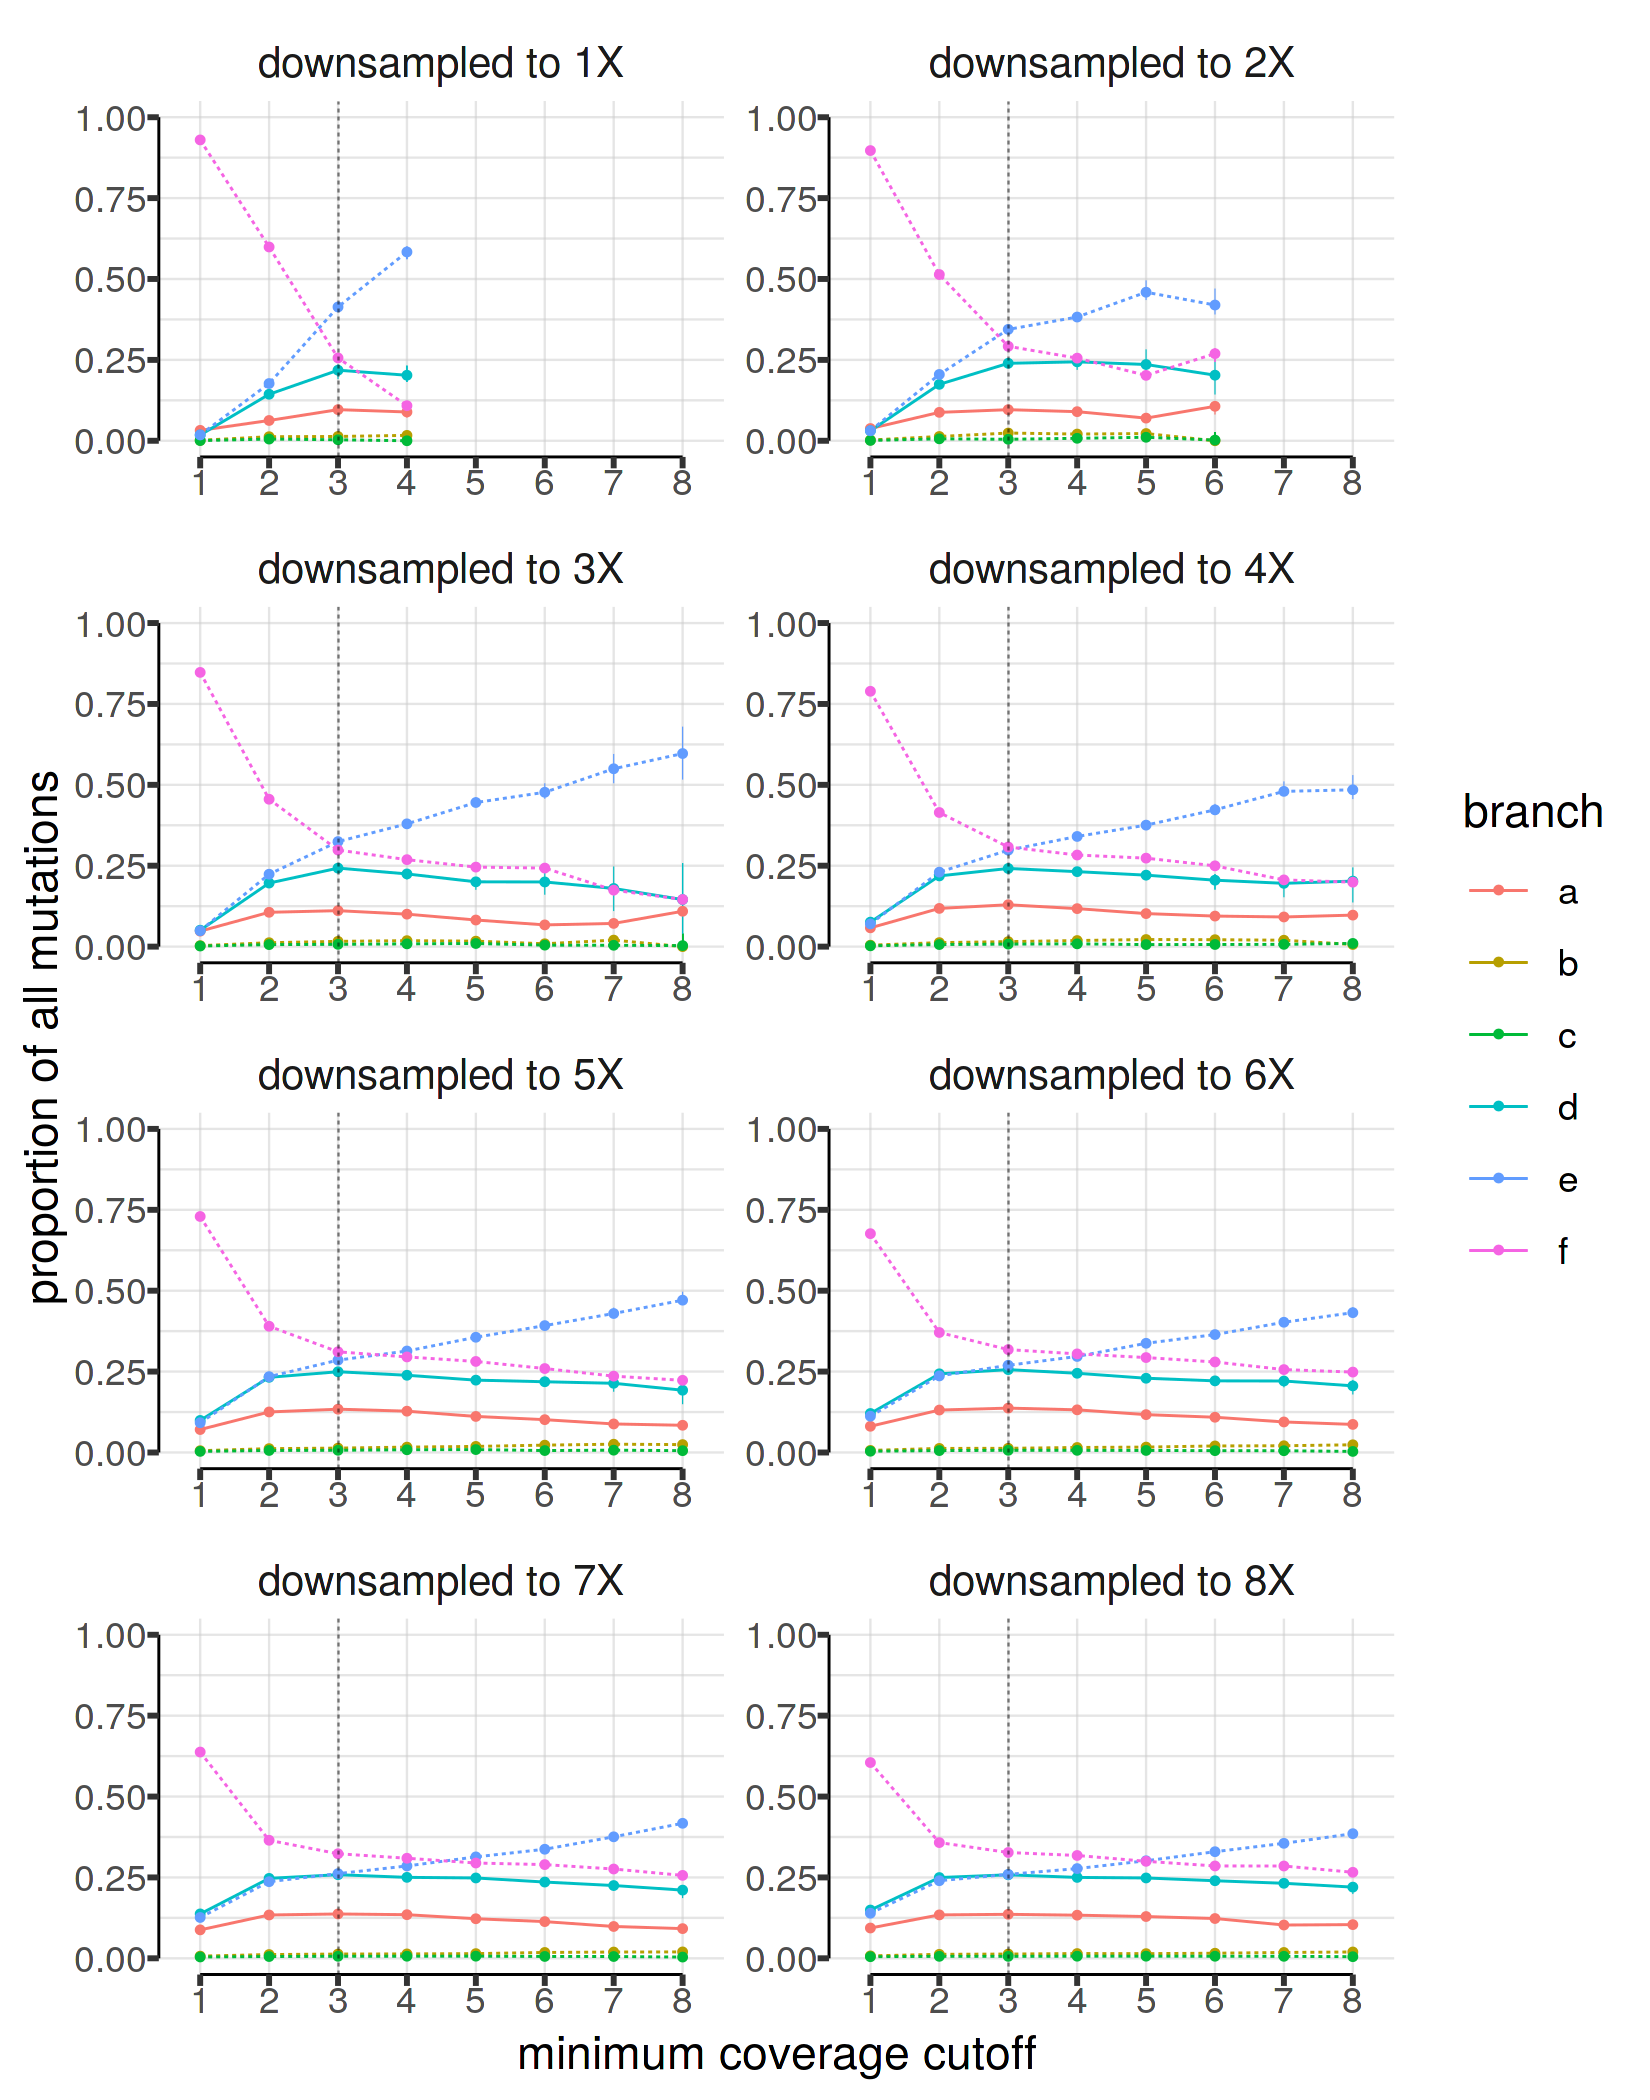

In [10]:
set_dim(5.5, 7)

tmrca_df %>%
    mutate(arch = str_replace(arch, "mez2_dp(\\d+)", "downsampled to \\1X")) %>%
    filter(filt == "filt50", capture == "full", arch %in% paste0("downsampled to ", 1:8, "X"), sites == "all", dp <= 8) %>%
branch_proportions

ggsave(here("figures/tmrca_estimates-branch_proportions_dp.png"), width = 5.5, height = 7)

### Same analysis but for all archaic Y chromosomes

Joining, by = c("arch", "dp", "sites", "branch")
Warning message:
“Removed 6 rows containing missing values (geom_path).”Warning message:
“Removed 12 rows containing missing values (geom_path).”Warning message:
“Removed 30 rows containing missing values (geom_point).”Warning message:
“Removed 6 rows containing missing values (geom_path).”Warning message:
“Removed 12 rows containing missing values (geom_path).”Warning message:
“Removed 30 rows containing missing values (geom_point).”

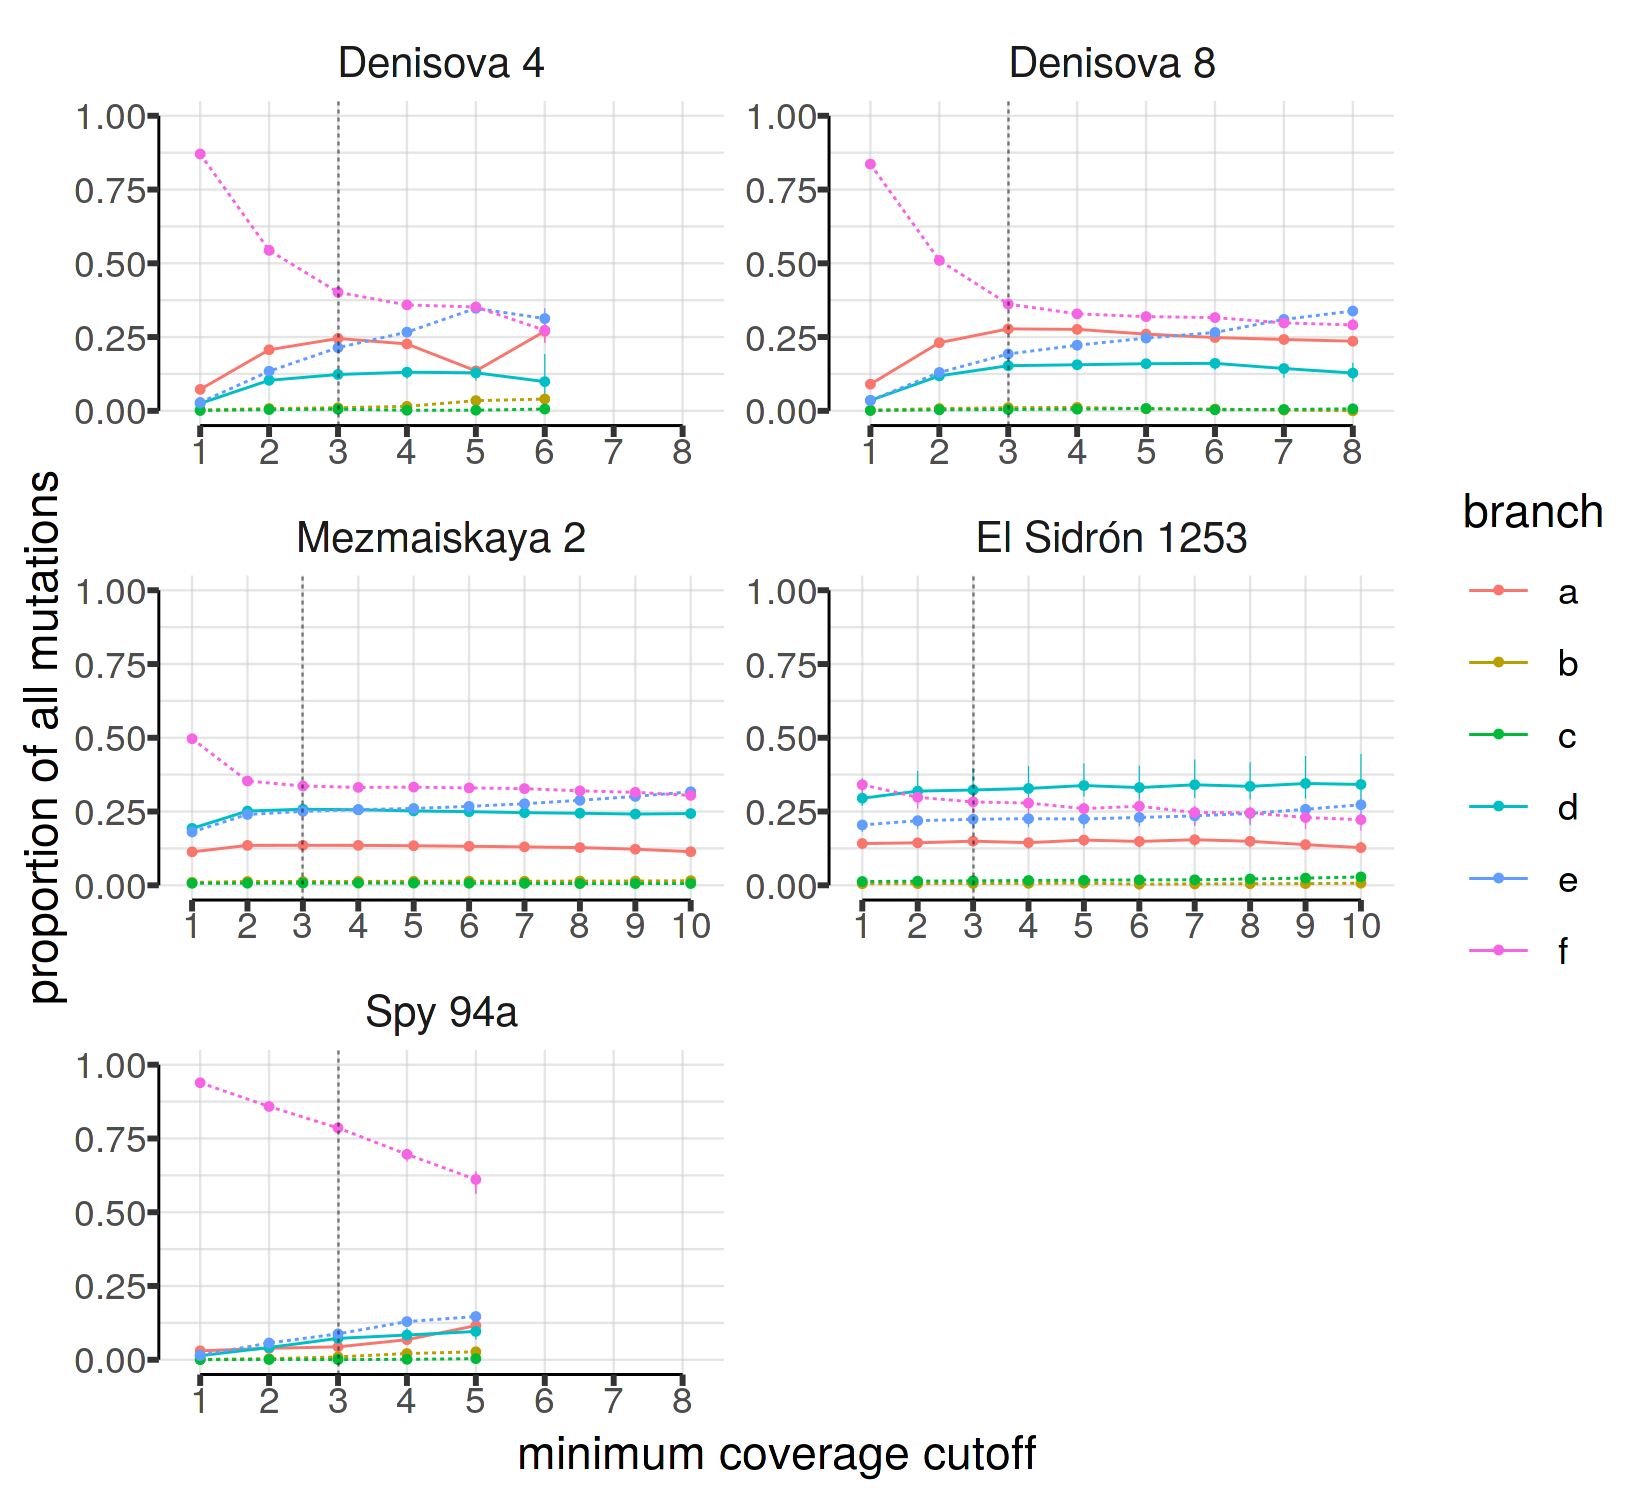

In [11]:
set_dim(5.5, 5)

tmrca_df %>%
filter(afr == "a00",
       capture == "lippold" & arch == "elsidron2" |
       capture == "full" & arch %in% c("mez2", "spy1", "den4", "den8"),
       sites == "all", dp <= 10, filt == "filt50") %>%
branch_proportions

ggsave(here("figures/tmrca_estimates-branch_proportions_arch.png"), width = 5.5, height = 5)

Warning message:
“Unknown levels in `f`: El Sidrón 1253, Spy 94a”Joining, by = c("arch", "dp", "sites", "branch")


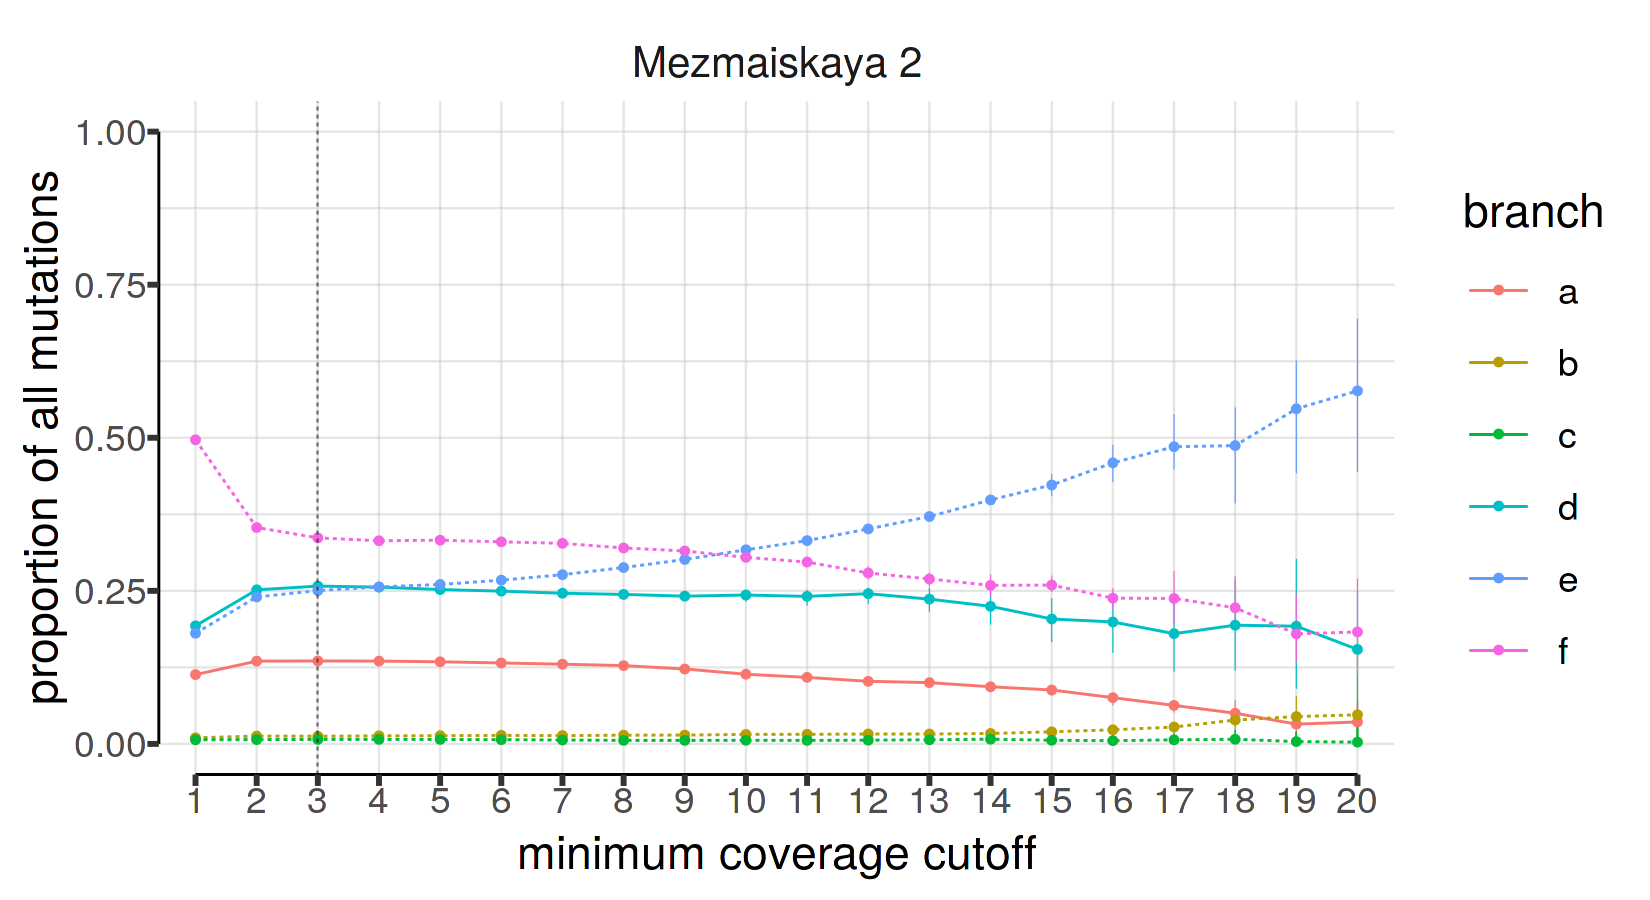

In [12]:
set_dim(5.5, 3)

tmrca_df %>%
filter(capture == "full" & arch == "mez2", sites == "all", filt == "filt50") %>%
branch_proportions

ggsave(here("figures/tmrca_estimates-branch_proportions_mez2.png"), width = 5.5, height = 3)

^^^ `a` and `f` appear to level after `dp >= 3` which seems OK???

but `e` is increasing steadily - this is super weird and could be driving `a / (a + d + e)` higher at higher cutoffs?
* is the increased proportion of `e` branch the reference bias signal?


# TMRCA estimates

In [13]:
# Filter sites/depth/capture regions/individuals
filter_tmrca <- function(stat, mindp, sites, filt, exclude = NA) {
    filter(
        tmrca_df,
        filt == !!filt,
        sites == !!sites & dp == mindp & capture == "full" & arch %in% c("den4", "den8", "mez2", "spy1", "shotgun_spy1", "shotgun_mez2", "mez2_snpad") |
        sites == !!sites & dp == mindp & capture == "lippold" & arch == "elsidron2" |
        dp %in% c(1, 3) & sites == "all" & capture == "exome" & arch == "elsidron1",
        !arch %in% exclude
    ) %>%
        mutate(arch = case_when(arch == "elsidron1" & dp == 1 ~ "elsidron_dp1",
                                arch == "elsidron1" & dp == 3 ~ "elsidron_dp3",
                                TRUE ~ arch))
}

In [14]:
# Combine archaic and A00 TMRCA data frames for further analysis
# Calculate confidence intervals for each reference individual by bootstrapping
get_ind_tmrca <- function(stat, mindp, sites, filt, exclude = NA) {
    arch_ind_ci <- filter_tmrca(stat, mindp, sites, filt, exclude) %>%
        add_step2_ci(per_ind = TRUE) %>%
        select(name = arch, ref, contains(stat)) %>%
        setNames(c("name", "ref", "tmrca", "high", "low"))

    afr_ind_ci <- step1 %>%
        add_step1_ci(per_ind = TRUE) %>%
        select(name = afr, ref, contains("tmrca_afr")) %>%
        filter(!name %in% exclude) %>%
        setNames(c("name", "ref", "tmrca", "high", "low"))

    bind_rows(arch_ind_ci, afr_ind_ci) %>% assign_set
}

In [15]:
get_overall_tmrca <- function(stat, mindp, sites, filt, exclude = NA) {
    arch <- filter_tmrca(stat, mindp, sites, filt, exclude)

    # overall archaic TMRCA values and CIs
    arch_overall <- arch %>%
        add_step2_ci(per_ind = FALSE) %>%
        select(name = arch, contains(stat)) %>%
        setNames(c("name", "tmrca", "high", "low"))
   
    # overall A00 TMRCA values and CIs
    afr_overall <- step1 %>%
        add_step1_ci(per_ind = FALSE) %>%
        select(name = afr, contains("tmrca_afr")) %>%
        filter(!name %in% exclude) %>%
        select(name, tmrca = tmrca_afr, low = tmrca_afr_low, high = tmrca_afr_high)

    bind_rows(arch_overall, afr_overall) %>% assign_set
}

In [16]:
plot_tmrca <- function(stat, mindp, sites, filt, ylabel = TRUE, exclude = NA, title = NA) {
    ind_tmrca <- get_ind_tmrca(stat, mindp, sites, filt, exclude)

    overall_tmrca <- get_overall_tmrca(stat, mindp, sites, filt, exclude)

    p <- ggplot() +
        # individual CIs
        geom_linerange(data = ind_tmrca, aes(name, ymin = low, ymax = high, group = ref, color = set),
                      position = position_dodge(width = 0.7), size = 1/5, alpha = 0.75) +

        # individual points
        geom_point(data = ind_tmrca, aes(name, tmrca, group = ref, color = set),
                      position = position_dodge(width = 0.7), size = 1/5, alpha = 0.75) +
        # average
        geom_segment(data = overall_tmrca, size = 1/3, linetype = 2,
                     aes(x = as.numeric(name) - 0.42, y = tmrca, xend = as.numeric(name) + 0.42, yend = tmrca)) +
        # upper bar
        geom_segment(data = overall_tmrca, size = 1/4,
                     aes(x = as.numeric(name) - 0.35, y = high, xend = as.numeric(name) + 0.35, yend = high)) +
        # lower bar
        geom_segment(data = overall_tmrca, size = 1/4,
                     aes(x = as.numeric(name) - 0.35, y = low, xend = as.numeric(name) + 0.35, yend = low)) +
        theme(axis.text.x = element_text(hjust = 1, angle = 45)) + 
        theme_classic() +
        scale_y_continuous(labels = comma) +
        theme(
            legend.position = "none",
            axis.text.x = element_text(hjust = 1, angle = 30, size = 13),
            axis.title.x = element_blank(),
            axis.line.x = element_blank(),
            axis.ticks.x = element_blank(),
            axis.text.y = element_text(size = 12),
            axis.title.y = element_text(size = 13),
            plot.subtitle = element_text(hjust = 1)
        ) +
        background_grid(major = "xy", minor = "xy", size.major = 0.2, size.minor = 0.2,
                        color.major = rgb(0.8, 0.8, 0.8, alpha = 0.5),
                        color.minor = rgb(0.8, 0.8, 0.8, alpha = 0.5)) +
        coord_capped_cart(ylim = c(200000, 1e6), left = "both")

    if (ylabel) {
        p <- p + ylab("TMRCA with a non-African [years ago]")
    } else {
        p <- p + theme(axis.title.y = element_blank())
    }

    if (is.na(title)) return(p)

    p + ggtitle("", subtitle = title)
}

Warning message:
“Unknown levels in `f`: Spy 94a (shotgun), Mezmaiskaya 2 (shotgun), Mezmaiskaya 2 (snpAD), A00”Warning message:
“Unknown levels in `f`: Spy 94a (shotgun), Mezmaiskaya 2 (shotgun), Mezmaiskaya 2 (snpAD), A00”

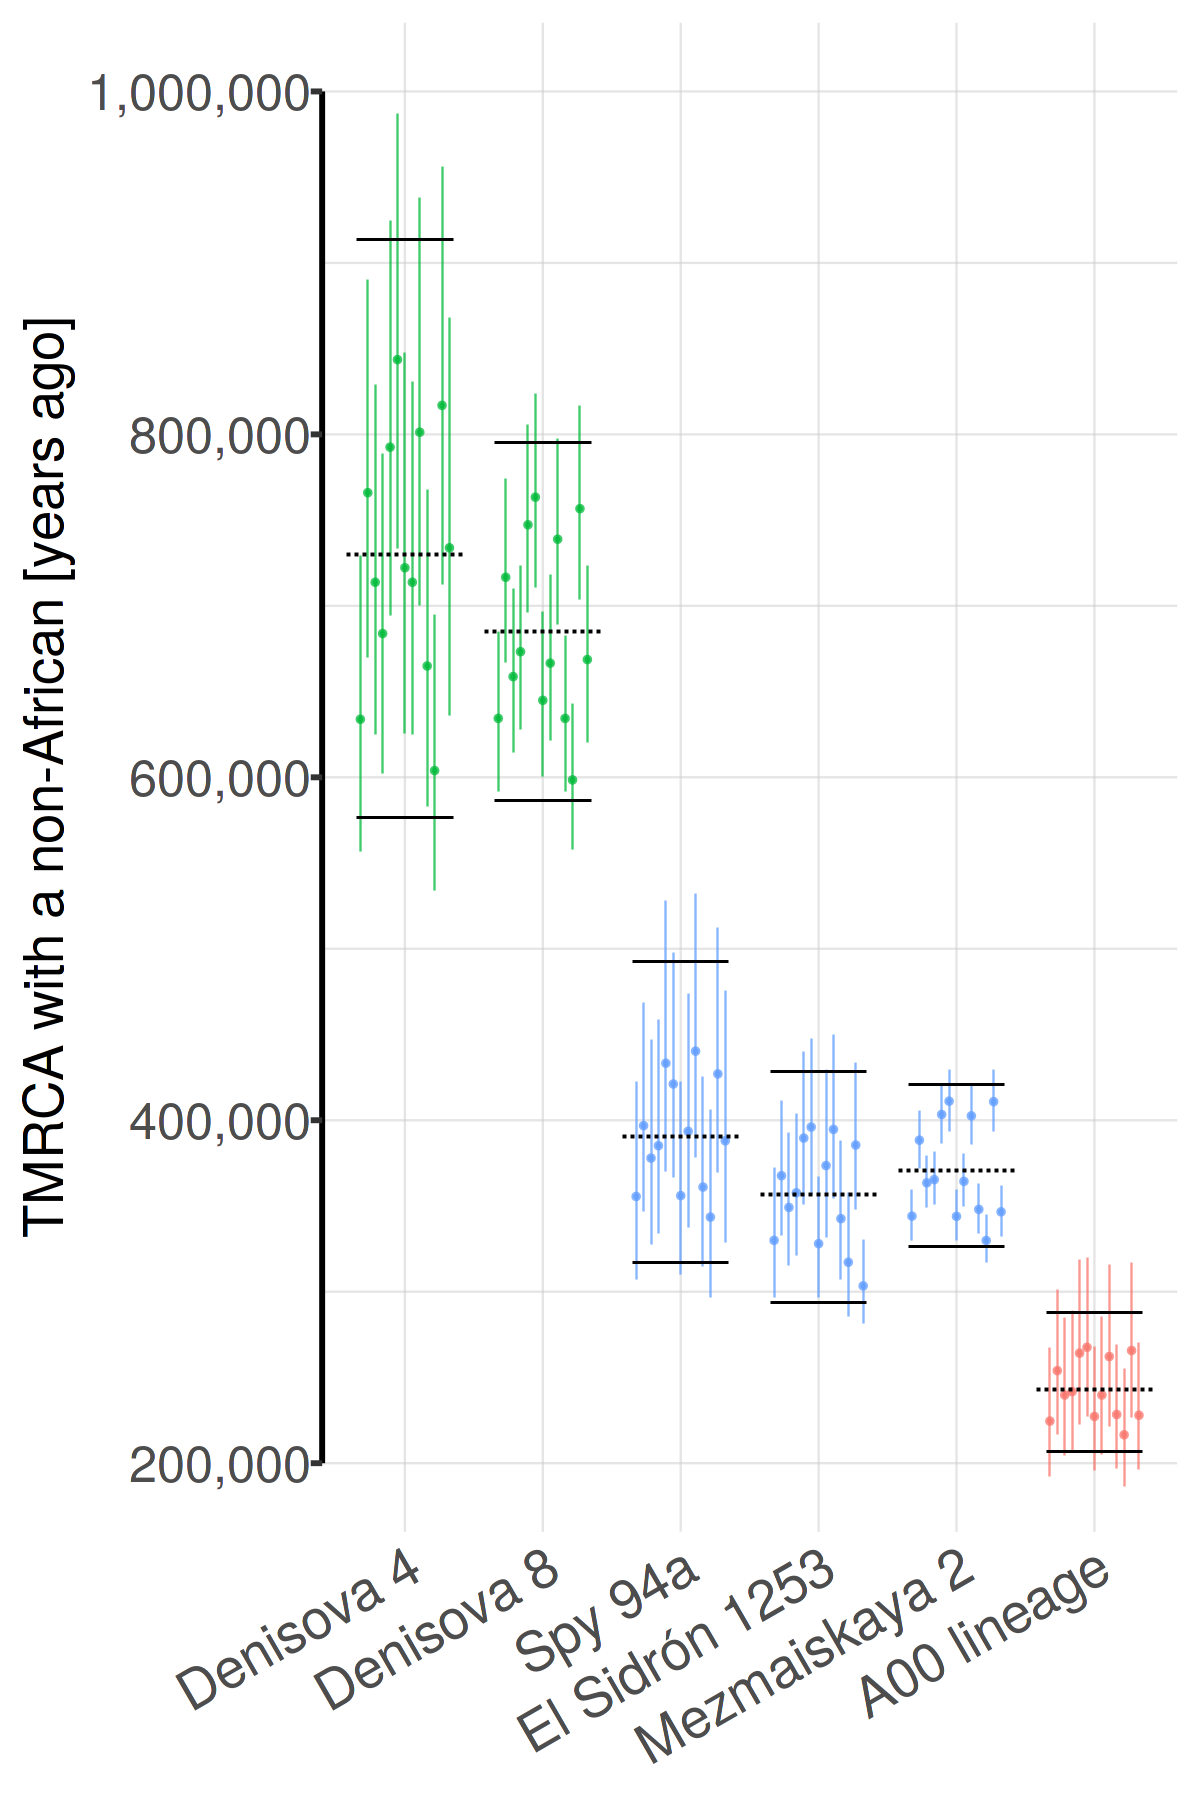

In [17]:
set_dim(4, 6)

plot_tmrca(stat = "new", mindp = 3, sites = "all", filt = "filt50", exclude = c("elsidron1", "shotgun_mez2", "shotgun_spy1", "mez2_snpad"))

ggsave(here("figures/tmrca_estimates-tmrca_main.png"), width = 6, height = 5)

Warning message:
“Unknown levels in `f`: Spy 94a (shotgun), Mezmaiskaya 2 (shotgun), Mezmaiskaya 2 (snpAD), A00”Warning message:
“Unknown levels in `f`: Spy 94a (shotgun), Mezmaiskaya 2 (shotgun), Mezmaiskaya 2 (snpAD), A00”Warning message:
“Unknown levels in `f`: Spy 94a (shotgun), Mezmaiskaya 2 (shotgun), Mezmaiskaya 2 (snpAD), A00”Warning message:
“Unknown levels in `f`: Spy 94a (shotgun), Mezmaiskaya 2 (shotgun), Mezmaiskaya 2 (snpAD), A00”Warning message:
“Unknown levels in `f`: Spy 94a (shotgun), Mezmaiskaya 2 (shotgun), Mezmaiskaya 2 (snpAD), A00”Warning message:
“Unknown levels in `f`: Spy 94a (shotgun), Mezmaiskaya 2 (shotgun), Mezmaiskaya 2 (snpAD), A00”Warning message:
“Unknown levels in `f`: Spy 94a (shotgun), Mezmaiskaya 2 (shotgun), Mezmaiskaya 2 (snpAD), A00”Warning message:
“Unknown levels in `f`: Spy 94a (shotgun), Mezmaiskaya 2 (shotgun), Mezmaiskaya 2 (snpAD), A00”

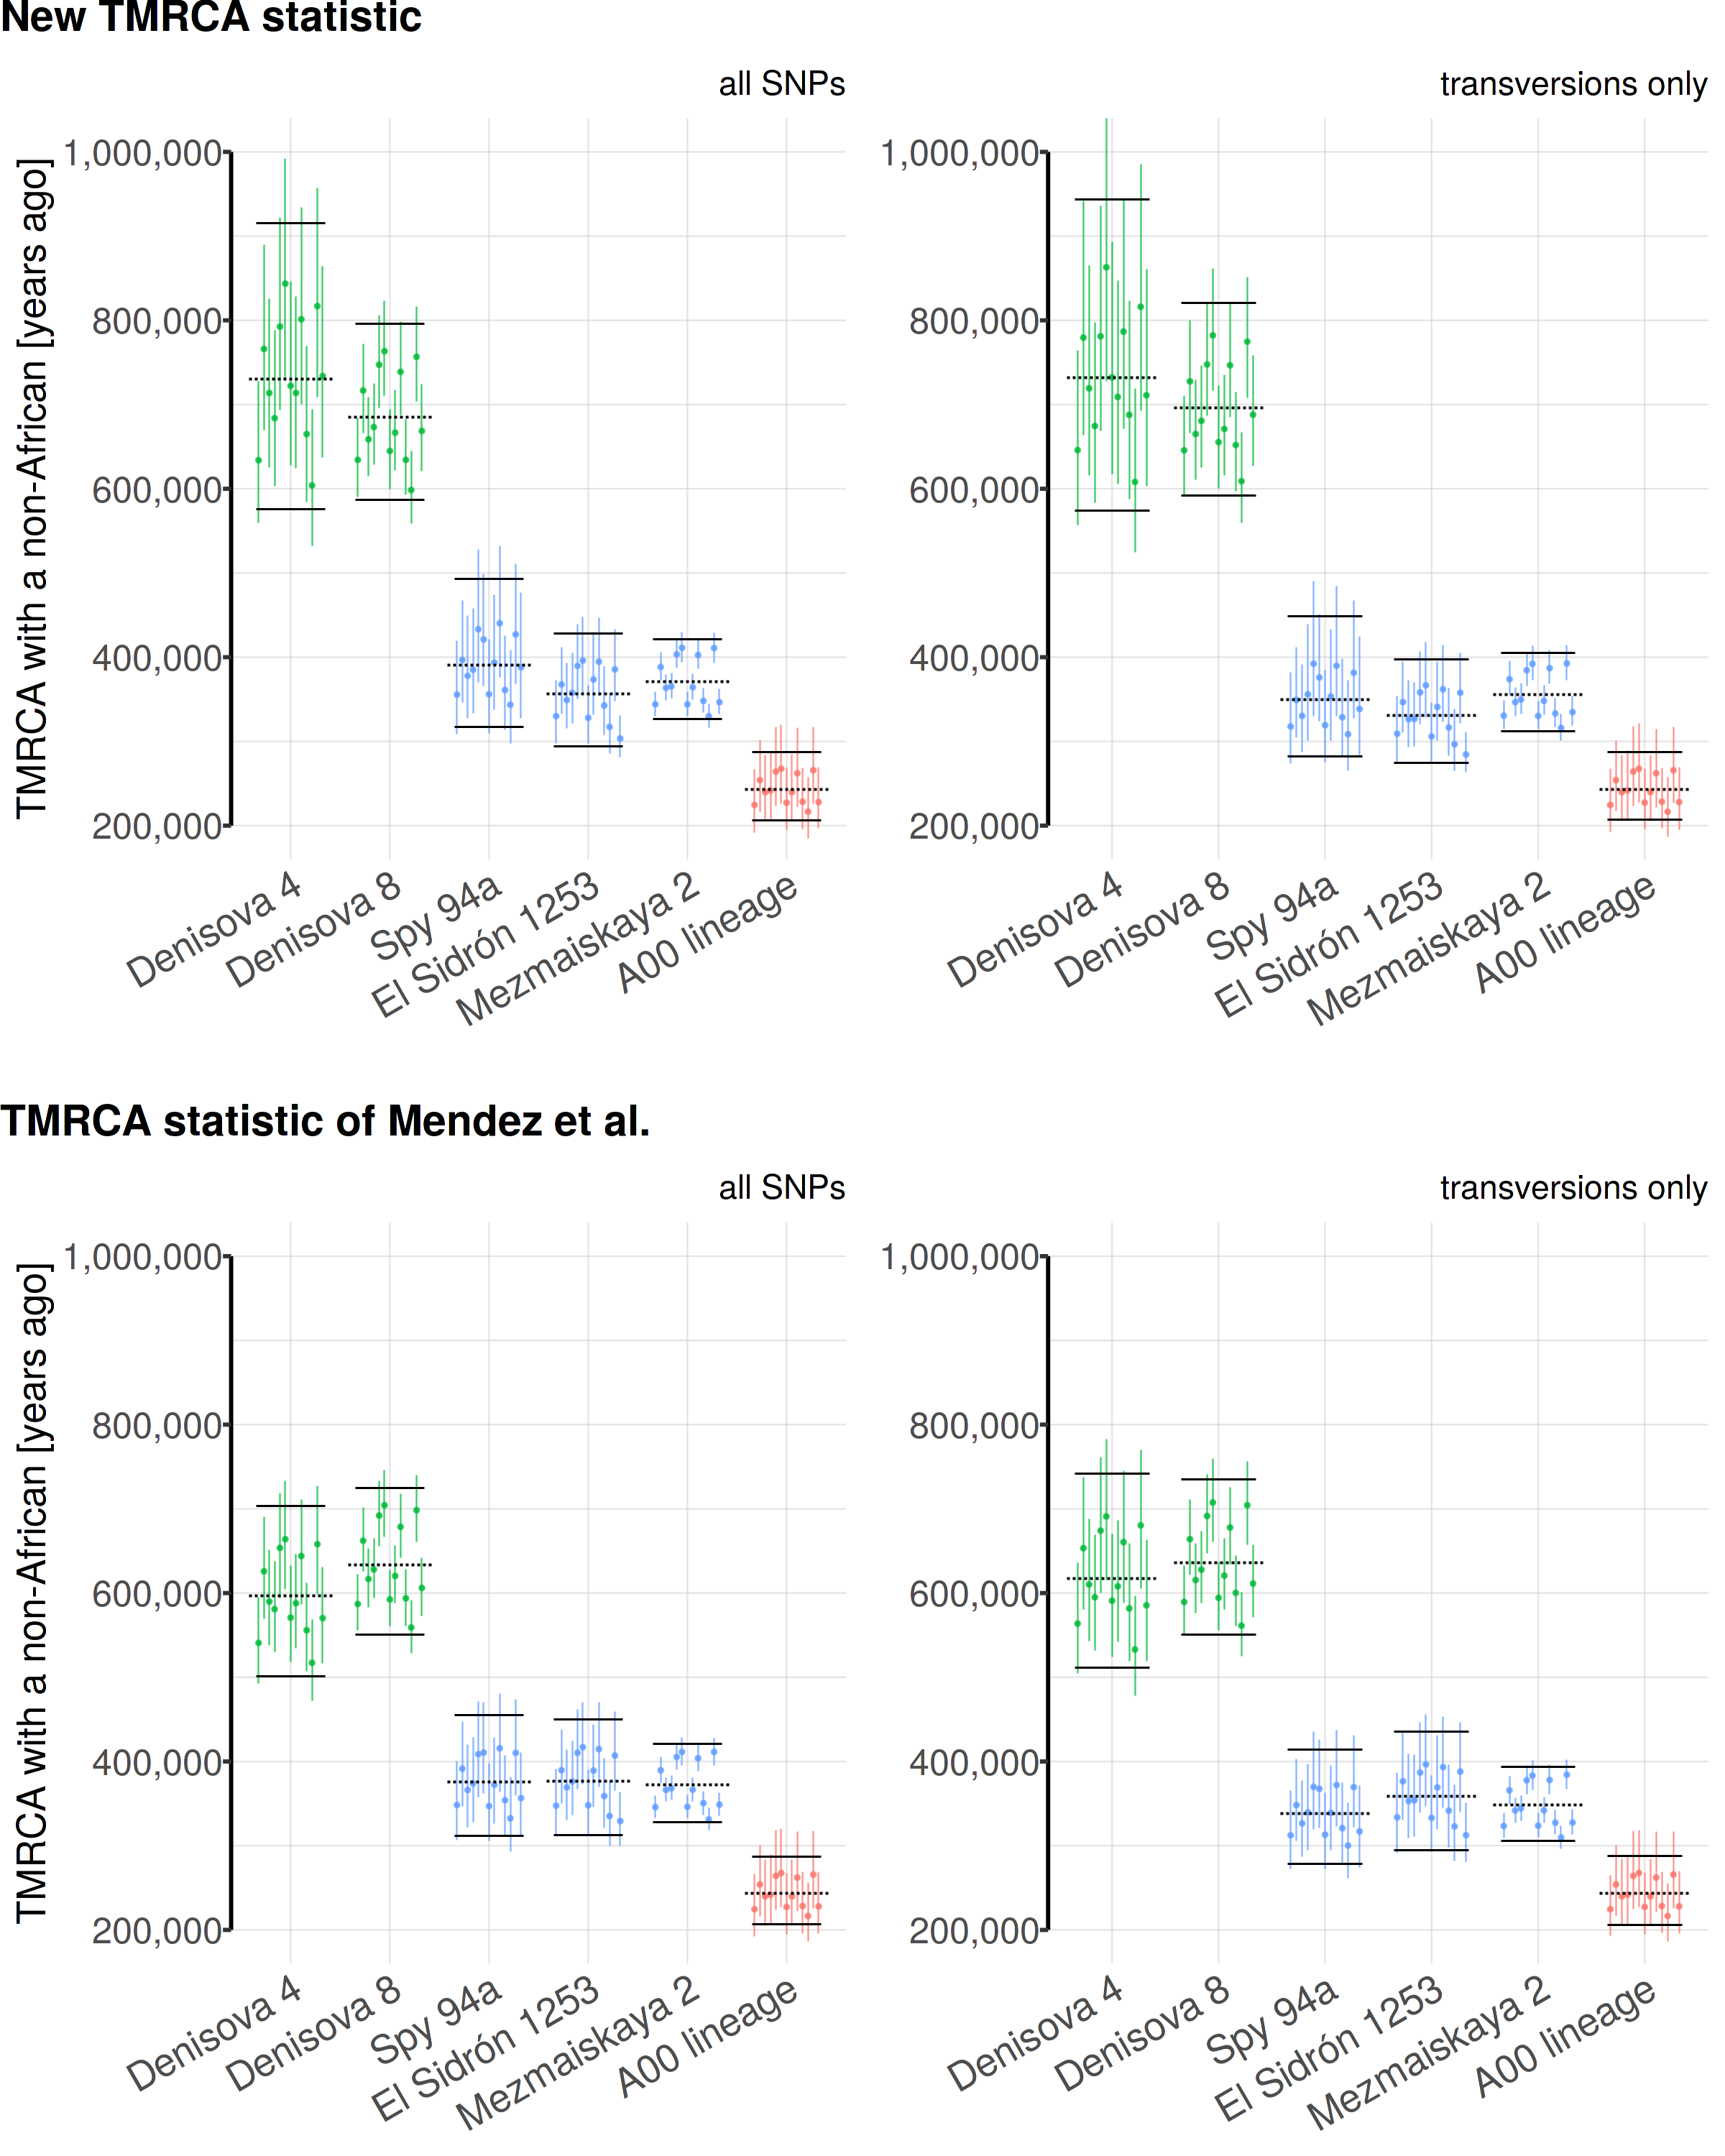

In [18]:
set_dim(8, 10)

p_new_all <- plot_tmrca(stat = "new", mindp = 3, sites = "all", filt = "filt50", exclude = c("elsidron1", "shotgun_mez2", "shotgun_spy1", "mez2_snpad"), title = "all SNPs")
p_new_tv <- plot_tmrca(stat = "new", mindp = 3, sites = "tv_only", filt = "filt50", exclude = c("elsidron1", "shotgun_mez2", "shotgun_spy1", "mez2_snpad"), title = "transversions only", ylabel = FALSE)

p_mendez_all <- plot_tmrca(stat = "mendez", mindp = 3, sites = "all", filt = "filt50", exclude = c("elsidron1", "shotgun_mez2", "shotgun_spy1", "mez2_snpad"), title = "all SNPs")
p_mendez_tv <- plot_tmrca(stat = "mendez", mindp = 3, sites = "tv_only", filt = "filt50", exclude = c("elsidron1", "shotgun_mez2", "shotgun_spy1", "mez2_snpad"), title = "transversions only", ylabel = FALSE)

plot_grid(
    p_new_all, p_new_tv, NULL, NULL, p_mendez_all, p_mendez_tv,    
    labels = c("New TMRCA statistic", "", "", "", "TMRCA statistic of Mendez et al.", ""),
    nrow = 3, hjust = "left", vjust = 1, rel_heights = c(1, 0.05, 1)
)

ggsave(here("figures/tmrca_estimates-tmrca_new_vs_mendez.png"), width = 8, height = 5)

Warning message:
“Unknown levels in `f`: A00”Warning message:
“Unknown levels in `f`: A00”Warning message:
“Unknown levels in `f`: A00”Warning message:
“Unknown levels in `f`: A00”

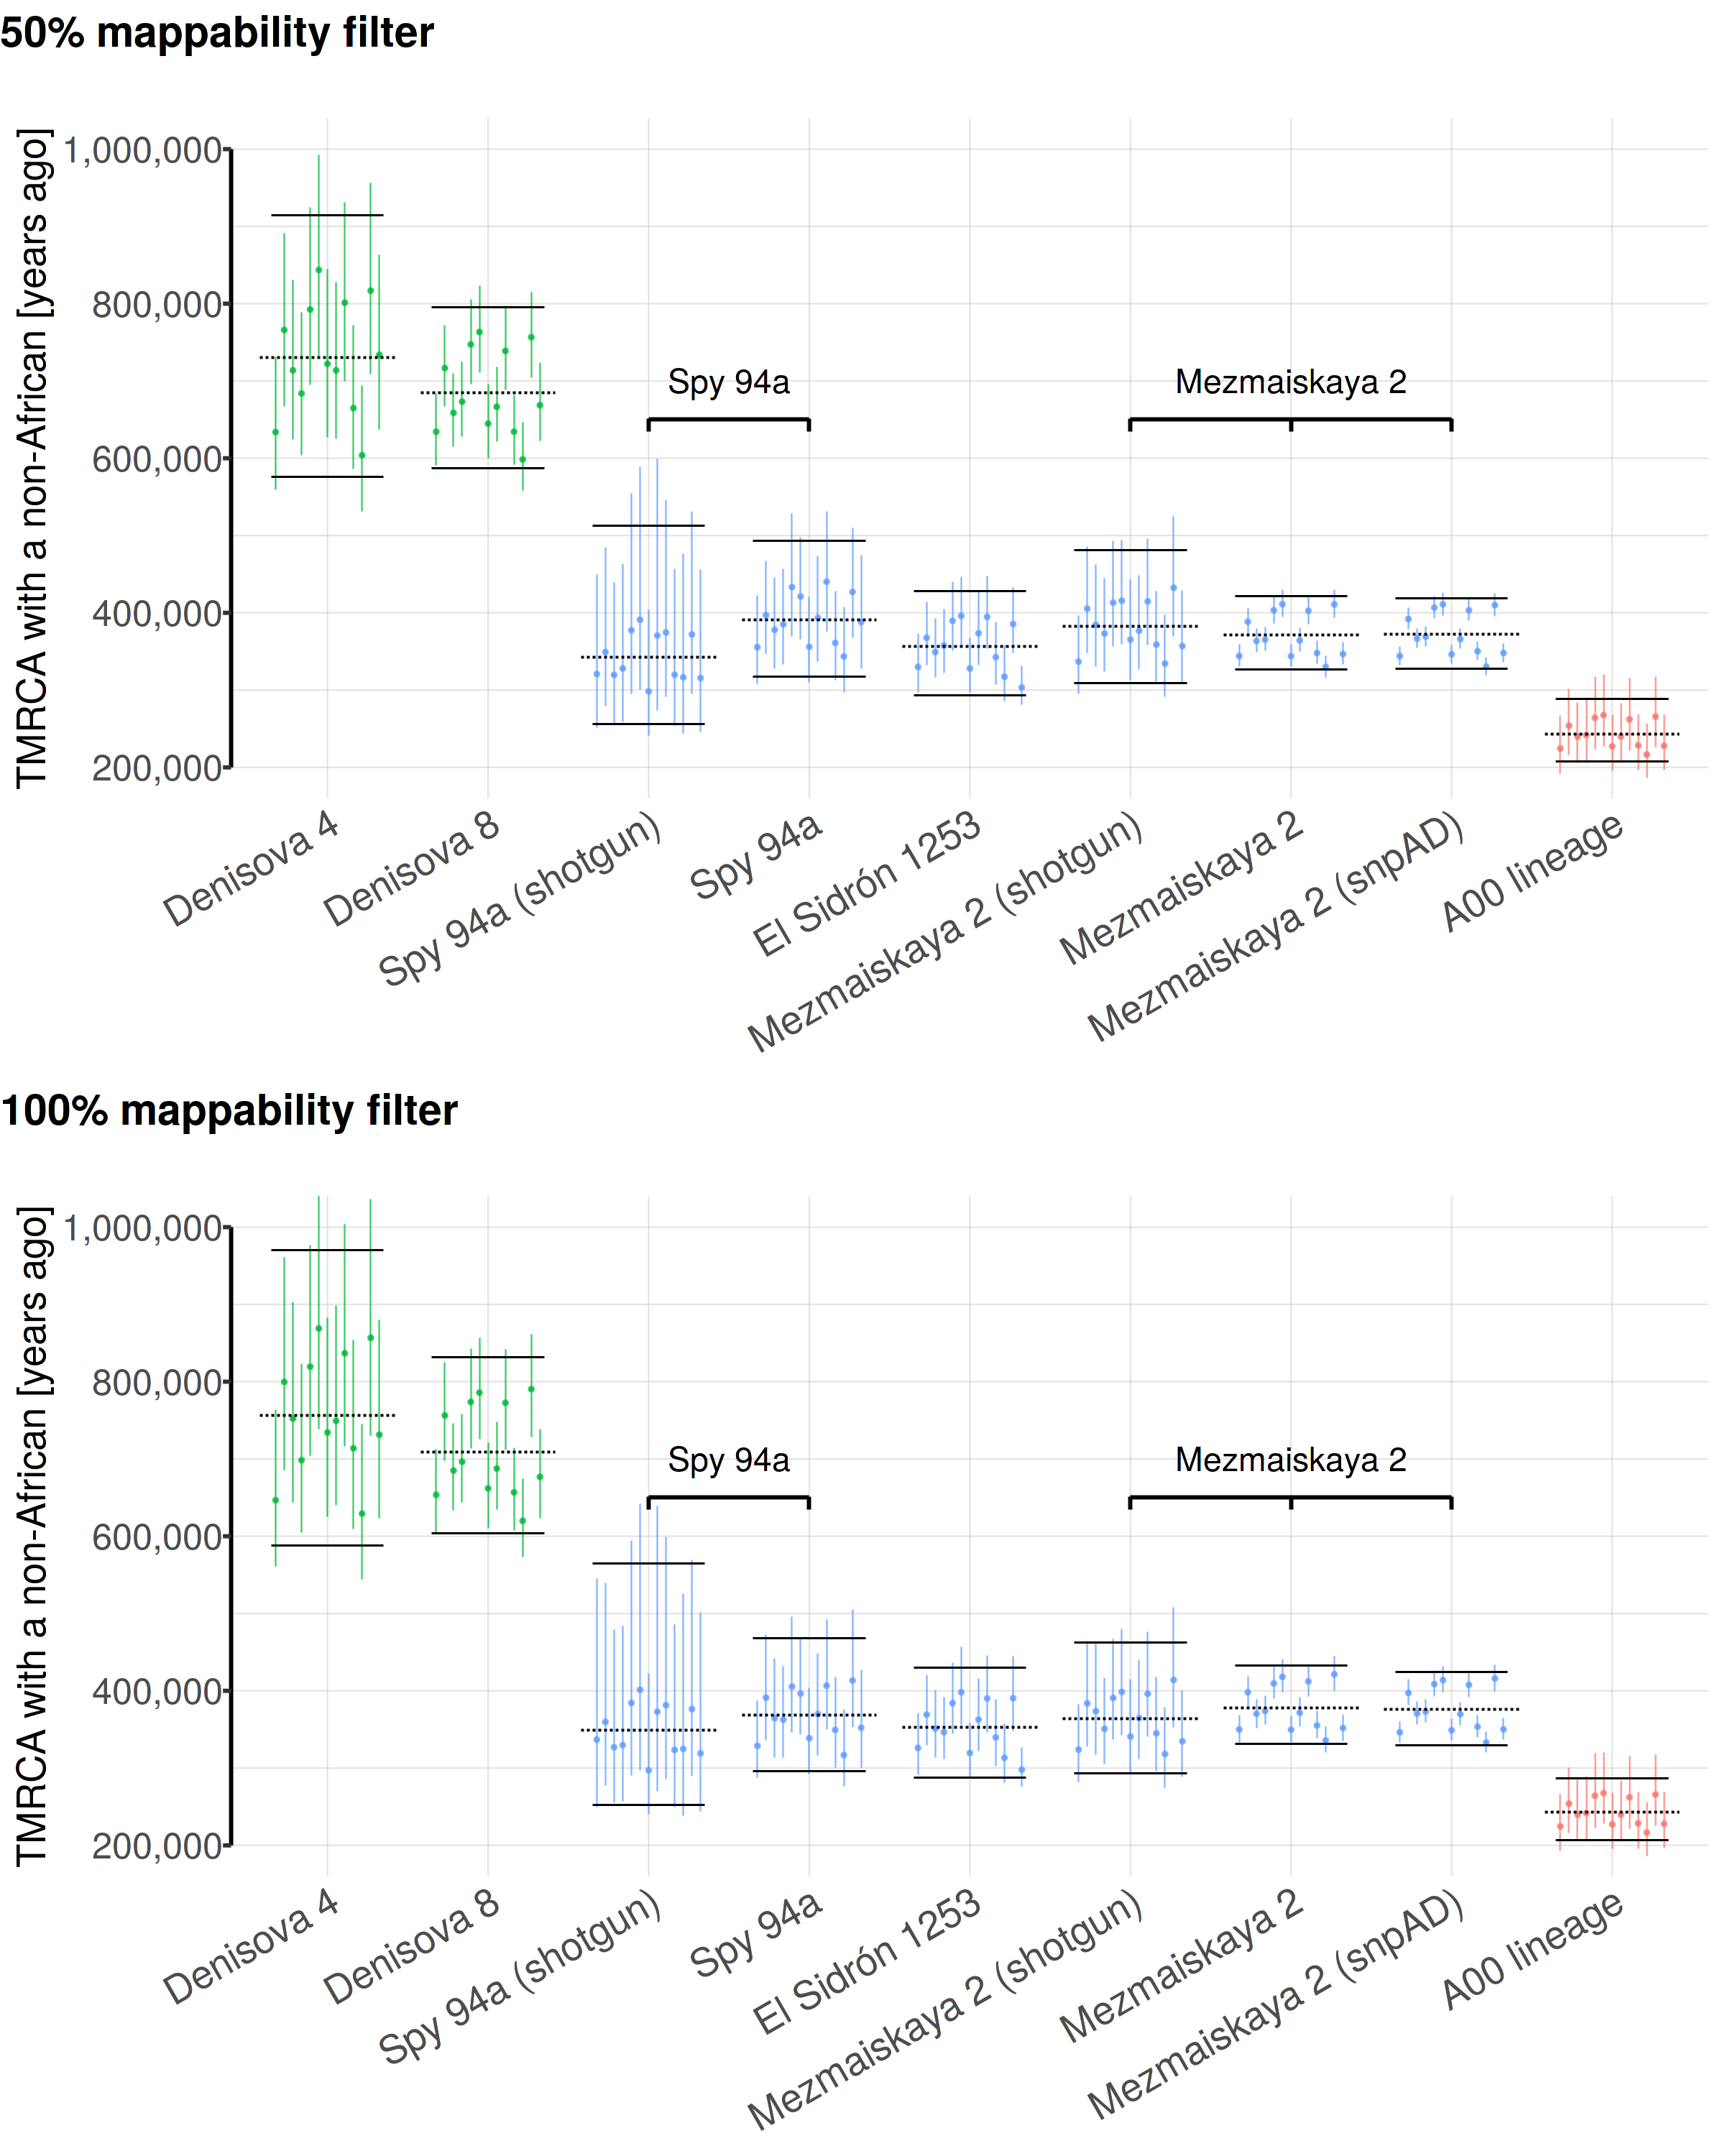

In [19]:
set_dim(8, 10)

p1_filt50 <- plot_tmrca(stat = "new", mindp = 3, sites = "all", filt = "filt50", exclude = c("elsidron1"), title = "") +
    geom_segment(aes(x = c(3, 6), xend = c(4, 8), y = 650000, yend = 650000)) +
    geom_segment(aes(x = c(3, 4, 6, 7, 8), xend = c(3, 4, 6, 7, 8), y = 651000, yend = 635000)) +
    geom_text(aes(x = c(3.5, 7), y = 700000, label = c("Spy 94a", "Mezmaiskaya 2")))

p1_filt100 <- plot_tmrca(stat = "new", mindp = 3, sites = "all", filt = "filt100", exclude = c("elsidron1"), title = "") +
    geom_segment(aes(x = c(3, 6), xend = c(4, 8), y = 650000, yend = 650000)) +
    geom_segment(aes(x = c(3, 4, 6, 7, 8), xend = c(3, 4, 6, 7, 8), y = 651000, yend = 635000)) +
    geom_text(aes(x = c(3.5, 7), y = 700000, label = c("Spy 94a", "Mezmaiskaya 2")))

plot_grid(p1_filt50, p1_filt100, nrow = 2,
          labels = c("50% mappability filter", "100% mappability filter"),
          hjust = "left")

ggsave(here("figures/tmrca_estimates-tmrca_new_shotgun_snpad.png"), width = 6, height = 5)

Warning message:
“Unknown levels in `f`: Spy 94a (shotgun), Mezmaiskaya 2 (shotgun), Mezmaiskaya 2 (snpAD), A00”Warning message:
“Unknown levels in `f`: Spy 94a (shotgun), Mezmaiskaya 2 (shotgun), Mezmaiskaya 2 (snpAD), A00”

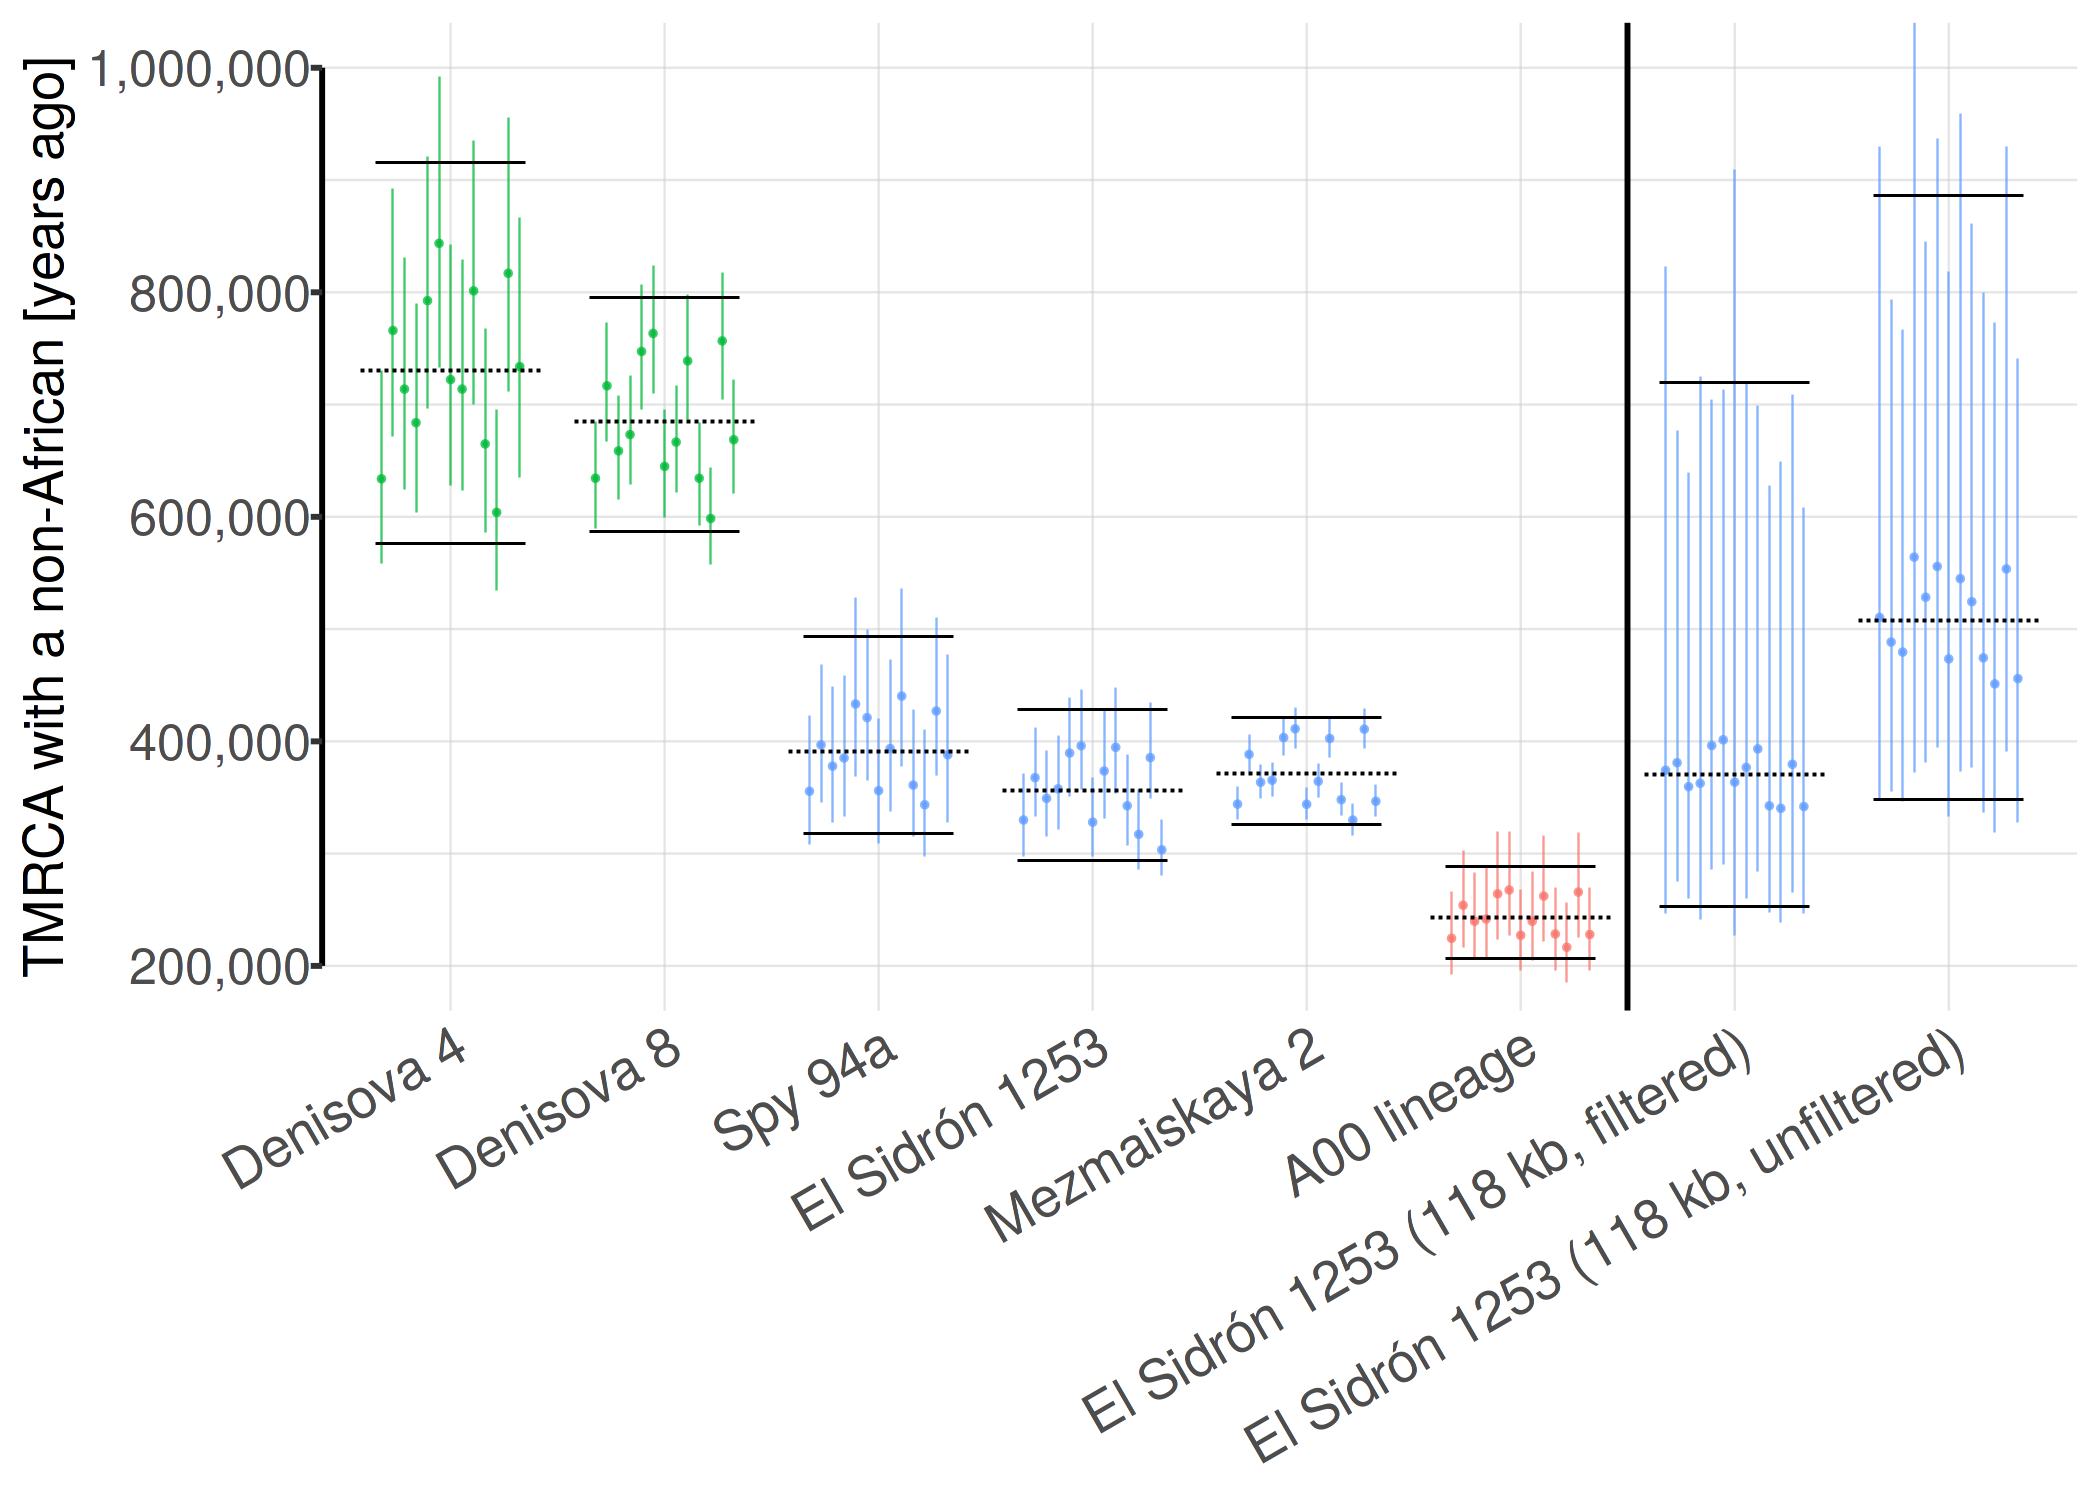

In [20]:
set_dim(7, 5)

plot_tmrca(stat = "new", mindp = 3, sites = "all", filt = "filt50", exclude = c("shotgun_mez2", "shotgun_spy1", "mez2_snpad")) +
    geom_vline(xintercept = c(6.5))

ggsave(here("figures/tmrca_old_sidron.png"), width = 6, height = 5)